
## GreenShift: A Tool for Analyzing Land Use and Land Cover Transitions ##
This script reads multi-year raster (GeoTIFF) data to identify and quantify land cover changes between different years. 
The output includes a CSV file with transition statistics and GeoTIFF files visualizing the changes.


In [26]:
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Define the input folder containing the raster data and the output path for the CSV summary

In [27]:

input_folder =r"D:\pythonCourse05-04-2024\Git_Hub\LULC_TMF_Data"
output_csv_path = r"D:\pythonCourse05-04-2024\Git_Hub\LULC_TMF_Data\Transition.csv"

## Define the years to analyze for land cover transitions.

In [28]:
years = [1990, 1995, 2000, 2005, 2010, 2015, 2020 ]

## Initialize an empty list to store the transition results.

In [29]:
results = []


## Function to calculate area in hectares

In [30]:

def calculate_area(pixel_sum, pixel_size):
    # Convert pixel size from square meters to hectares (1 hectare = 10,000 m²)
    area_ha = (pixel_sum * pixel_size) / 10000
    return area_ha


## Loop through each consecutive pair of years to compare land cover.

In [31]:
for i in range(len(years) - 1):
    year1 = years[i]
    year2 = years[i + 1]
    raster1_path = os.path.join(input_folder, f"{year1}.tif")
    raster2_path = os.path.join(input_folder, f"{year2}.tif")
    
    # Define a specific output path for the current year transition GeoTIFF
    output_tif_path = os.path.join(input_folder, f"LULC_transition_{year1}_{year2}.tif")

    # Check if both raster files exist
    if not os.path.exists(raster1_path) or not os.path.exists(raster2_path):
        print(f"Skipping year pair {year1}-{year2} due to missing file(s).")
        continue

    # Open the raster files
    with rasterio.open(raster1_path) as raster1, rasterio.open(raster2_path) as raster2:
        # Read the raster data
        data1 = raster1.read(1)
        data2 = raster2.read(1)

        # Calculate pixel size (assuming square pixels)
        pixel_size = raster1.res[0] * raster1.res[1]

        # Create an empty array for storing transitions for GeoTIFF output
        transition_raster = np.zeros_like(data1, dtype=np.uint16) 

        # Loop through each unique value in the first raster
        for ref_class in np.unique(data1):
            if ref_class == raster1.nodata:
                continue

            # Mask to get the corresponding values in the second raster
            mask = data1 == ref_class
            new_classes, counts = np.unique(data2[mask], return_counts=True)

            # If no new class found, add an entry for no change
            if len(new_classes) == 0:
                change_class = f"C_{int(ref_class)} - NoChange"  # Prefix to avoid date interpretation
                pixel_sum = np.sum(mask)  # Total pixels with the reference class
                area_ha = calculate_area(pixel_sum, pixel_size)

                # Append the result to the results list
                results.append({
                    'Year': f"{year1}-{year2}",
                    'ReferenceClass': int(ref_class),
                    'NewClass': 'NoChange',
                    'ChangeClass': change_class,
                    'PixelSum': pixel_sum,
                    'Area (Ha)': area_ha
                })

            # Loop through each new class and calculate the transition
            for new_class, pixel_sum in zip(new_classes, counts):
                if new_class == raster2.nodata:
                    continue

                # Format the change class with a prefix
                change_class = f"{int(ref_class)} - {int(new_class)}"  # Prefix to avoid date interpretation
                area_ha = calculate_area(pixel_sum, pixel_size)

                # Append the result to the results list
                results.append({
                    'Year': f"{year1}-{year2}",
                    'ReferenceClass': int(ref_class),
                    'NewClass': int(new_class),
                    'ChangeClass': change_class,
                    'PixelSum': pixel_sum,
                    'Area (Ha)': area_ha
                })

                # Add transition info to transition_raster for GeoTIFF output (arbitrary example of transition code)
                transition_code = ref_class * 1000 + new_class  # Example: encode transitions uniquely
                transition_raster[mask & (data2 == new_class)] = transition_code

        # Save the transition raster for the specific year pair as GeoTIFF
        with rasterio.open(
            output_tif_path,
            'w',
            driver='GTiff',
            height=transition_raster.shape[0],
            width=transition_raster.shape[1],
            count=1,
            dtype=transition_raster.dtype,
            crs=raster1.crs,  # Use the CRS of the original rasters
            transform=raster1.transform
        ) as dst:
            dst.write(transition_raster, 1)
        
        print(f"Transition raster for {year1}-{year2} saved to {output_tif_path}")


Transition raster for 1990-1995 saved to D:\pythonCourse05-04-2024\Git_Hub\LULC_TMF_Data\LULC_transition_1990_1995.tif
Transition raster for 1995-2000 saved to D:\pythonCourse05-04-2024\Git_Hub\LULC_TMF_Data\LULC_transition_1995_2000.tif
Transition raster for 2000-2005 saved to D:\pythonCourse05-04-2024\Git_Hub\LULC_TMF_Data\LULC_transition_2000_2005.tif
Transition raster for 2005-2010 saved to D:\pythonCourse05-04-2024\Git_Hub\LULC_TMF_Data\LULC_transition_2005_2010.tif
Transition raster for 2010-2015 saved to D:\pythonCourse05-04-2024\Git_Hub\LULC_TMF_Data\LULC_transition_2010_2015.tif
Transition raster for 2015-2020 saved to D:\pythonCourse05-04-2024\Git_Hub\LULC_TMF_Data\LULC_transition_2015_2020.tif


## Convert results to a DataFrame and save to Excel

In [32]:

df = pd.DataFrame(results)

# Specify the path for the output Excel file
output_excel_path = os.path.join(input_folder, 'LULC_changes.xlsx')

# Save to Excel
df.to_excel(output_excel_path, index=False, engine='openpyxl')
print(f"Results saved to {output_excel_path}")


Results saved to D:\pythonCourse05-04-2024\Git_Hub\LULC_TMF_Data\LULC_changes.xlsx


## Automated Visualization

<Figure size 1200x600 with 0 Axes>

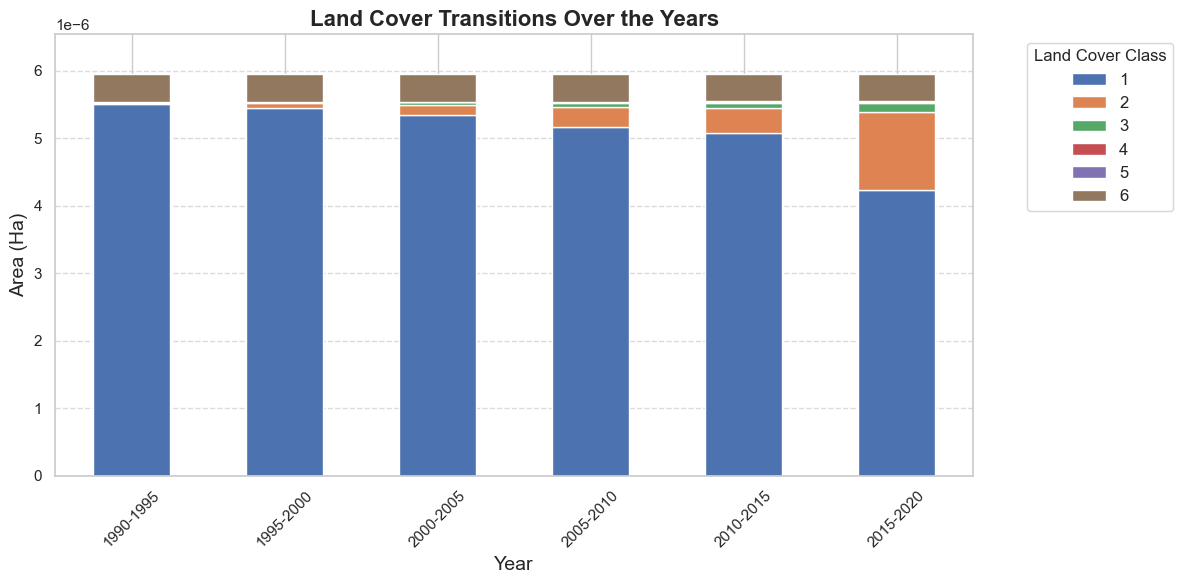

In [38]:

# Group by year and reference class to prepare data for visualization
visualization_data = df.groupby(['Year', 'ReferenceClass'])['Area (Ha)'].sum().unstack().fillna(0)

# Set the style using seaborn
sns.set(style='whitegrid')

# Plotting the land cover transitions
plt.figure(figsize=(12, 6))  # Increase figure size for better visibility
ax = visualization_data.plot(kind='bar', stacked=True, figsize=(12, 6), width=0.5)  # Thinner bars

# Customize the aesthetics
plt.title('Land Cover Transitions Over the Years', fontsize=16, fontweight='bold')
plt.xlabel('Year', fontsize=14)
plt.ylabel('Area (Ha)', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Land Cover Class', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add horizontal grid lines

# Set x and y limits for better fit
plt.xlim(-0.5, len(visualization_data) - 0.5)
plt.ylim(0, visualization_data.sum(axis=1).max() * 1.1)  # 10% padding on the top

# Save the plot to a file
plt.tight_layout()
plt.savefig(os.path.join(input_folder, 'land_cover_transitions.png'), dpi=300)  # Save with high resolution
plt.show()
